# DIGI405-19S2 Lab Exercise 2c: Named Entity Recognition Extension Notebook

## Preparing for this lab exercise

The lecture and lab notebook from week six are relevant in preparing for this task. 

## Introduction

This task will get you to train a named entity recognition (NER) model using a tiny data-set and to think through some of the issues in detecting named entities. The task code is based on the example provided on the Spacy website here: https://spacy.io/usage/training#example-new-entity-type

Our named entity recogniser will attempt to detect the names of iwi. Iwi are a fundamental social grouping in Māori society, both before and after British colonisation. Iwi are introduced in detail here: https://teara.govt.nz/en/tribal-organisation/page-1. Please read through this page and the linked pages on Māori tribal organisation: https://teara.govt.nz/en/tribal-organisation, including the page on iwi names and history. 

Iwi affiliations are a key aspect of the social identity of many Māori. For example, in formal occasions or when meeting for the first time, it is common for Māori (and people of other ancestry in New Zealand) to introduce themselves with reference to their iwi and their genealogy. See discussion here: https://www.otago.ac.nz/maori/world/tikanga/whakapapa/index.html.

There is information on the geographic regions associated with each iwi on this page: http://www.tkm.govt.nz/map/

You can also find discussion of iwi and issues around naming and classification on the Statistics New Zealand page here: http://archive.stats.govt.nz/methods/classifications-and-standards/classification-related-stats-standards/iwi.aspx. This page also links to an Excel spreadsheet of iwi names.

## Lab exercise instructions

**Type your name:**

AncyJohn

**Type your Student ID number:**

52770710

The questions are at the end of this document. The first set of cells introduce some code for training a NER model. You will then be required to repeat the process with your own examples, do some analysis of the results, and identify some issues we would need to think more about to train a more robust model.

Run the next cell to import the required libraries.

In [2]:
from __future__ import unicode_literals, print_function
import random
from pathlib import Path
import spacy
from spacy.util import minibatch, compounding

Here is some sample text from the Wikipedia entry for "Iwi": https://en.wikipedia.org/wiki/Iwi

In [3]:
text = '''Iwi are the largest social units in Aotearoa Māori society. The Māori-language word iwi means "people" or "nation", and is often translated as "tribe", or "a confederation of tribes". The word is both singular and plural in Māori.

Iwi groups trace their ancestry to the original Polynesian migrants who, according to tradition, arrived from Hawaiki. Some iwi cluster into larger groupings that are based on whakapapa (genealogical tradition) and known as waka (literally "canoes", with reference to the original migration voyages). These super-groupings generally serve symbolic rather than practical functions. In pre-European times, most Māori were allied to relatively small groups in the form of hapū ("sub-tribes") and whānau ("family"). Each iwi contains a number of hapū; among the hapū of the Ngāti Whātua iwi, for example, are Te Uri-o-Hau, Te Roroa, Te Taoū, and Ngāti Whātua-o-Ōrākei.

In modern-day New Zealand, iwi can exercise significant political power in the recovery and management of land and of other assets. (Note for example the 1997 Treaty of Waitangi settlement between the New Zealand Government and Ngāi Tahu, compensating that iwi for various losses of the rights guaranteed under the Treaty of Waitangi of 1840.) Iwi affairs can have a real impact on New Zealand politics and society. A 2004 attempt by some iwi to test in court their ownership of the seabed and foreshore areas polarised public opinion (see New Zealand foreshore and seabed controversy). '''

print(text)

Iwi are the largest social units in Aotearoa Māori society. The Māori-language word iwi means "people" or "nation", and is often translated as "tribe", or "a confederation of tribes". The word is both singular and plural in Māori.

Iwi groups trace their ancestry to the original Polynesian migrants who, according to tradition, arrived from Hawaiki. Some iwi cluster into larger groupings that are based on whakapapa (genealogical tradition) and known as waka (literally "canoes", with reference to the original migration voyages). These super-groupings generally serve symbolic rather than practical functions. In pre-European times, most Māori were allied to relatively small groups in the form of hapū ("sub-tribes") and whānau ("family"). Each iwi contains a number of hapū; among the hapū of the Ngāti Whātua iwi, for example, are Te Uri-o-Hau, Te Roroa, Te Taoū, and Ngāti Whātua-o-Ōrākei.

In modern-day New Zealand, iwi can exercise significant political power in the recovery and management

We're going to check to see what named entities Spacy detects using one of its pre-trained models.

In [4]:
nlp = spacy.load('en_core_web_sm')
doc = nlp(text)
for ent in doc.ents:
    print(ent.label_, ent.text)

GPE Aotearoa Māori
PERSON Māori
GPE Māori
NORP Polynesian
GPE Hawaiki
NORP pre-European
PERSON Māori
FAC the Ngāti Whātua
PERSON Te Uri-
PERSON Te Roroa
ORG Te Taoū
PERSON Ngāti Whātua-o-Ōrākei
DATE modern-day
GPE New Zealand
DATE 1997
EVENT Treaty of Waitangi
ORG the New Zealand Government
PERSON Ngāi Tahu
LAW the Treaty of Waitangi of 1840
GPE New Zealand
DATE 2004
GPE New Zealand


Take a look at the text above and the named entities that have been detected. Several iwi names are being classified incorrectly (e.g. Ngāi Tahu, the largest iwi in the South Island - Te Waipounamu, is classified as "PERSON"). We might question where an iwi fits in the NER types used by Spacy (see https://spacy.io/api/annotation#named-entities). For example, is an iwi an ORG or a NORP? We might question whether aspects of the social identity and social organisation of indigenous peoples are captured by classifications that derive their meaning from capitalist and colonial systems of knowledge organisation. In addition, even if we decided that iwi fitted the ORG or NORP categories, iwi are likely to be neglected in the data used to train the NER models.

### Training a named entity recogniser for "IWI"

We're going to now train a completely new model based on the code provided here: https://spacy.io/usage/training#example-new-entity-type. This webpage contains more information on training models with Spacy that is relevant background for this task.

We need a label for our new entity:

In [5]:
# new entity label
LABEL = "IWI"

The next cell contains a function definition we will use to train our model. A reminder that this is adapted from https://spacy.io/usage/training#example-new-entity-type. You might want to read this to get more of an understanding of the code, but you can complete the task without understanding everything about this code. The function includes some default variables used in training. You don't need to change these for this exercise. We are going to create a new model to detect iwi rather than adapting an existing model.

In [6]:
# we don't want to preload an existing spacy model - we just want a blank one
# n_iter is the number of training iterations, I'm using what the Spacy example used
def train_ner(model=None, n_iter=30):
    random.seed(0)
    if model is not None:
        nlp = spacy.load(model)  # load existing spaCy model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank("en")  # create blank Language class
        print("Created blank 'en' model")
    # Add entity recognizer to model if it's not in the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if "ner" not in nlp.pipe_names:
        ner = nlp.create_pipe("ner")
        nlp.add_pipe(ner)
    # otherwise, get it, so we can add labels to it
    else:
        ner = nlp.get_pipe("ner")

    ner.add_label(LABEL)  # add new entity label to entity recognizer
    # Adding extraneous labels shouldn't mess anything up e.g. ner.add_label("VEGETABLE")
    if model is None:
        optimizer = nlp.begin_training()
    else:
        optimizer = nlp.resume_training()
    move_names = list(ner.move_names)
    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
    with nlp.disable_pipes(*other_pipes):  # only train NER
        sizes = compounding(1.0, 4.0, 1.001)
        # batch up the examples using spaCy's minibatch
        for itn in range(n_iter):
            random.shuffle(TRAIN_DATA)
            batches = minibatch(TRAIN_DATA, size=sizes)
            losses = {}
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(texts, annotations, sgd=optimizer, drop=0.35, losses=losses)
            print("Losses", losses)
    return nlp

To create some training data we need to gather some sentences and annotate the entities. To annotate the entities we need to know the start and end character positions of the entity in a string. In the example sentence:   
`The Takiwā over which Ngāi Tahu holds rangatiratanga extends over 80 percent of Te Waipounamu (the South Island)`  
the iwi name Ngāi Tahu begins at position 22 and ends at position 31.

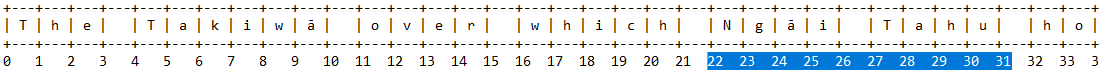

The following cell contains some code to show you how to splice a string to verify you have the start and end character positions correct.

In [7]:
example = 'The Takiwā over which Ngāi Tahu holds rangatiratanga extends over 80 percent of Te Waipounamu (the South Island)'
example[22:31]

'Ngāi Tahu'

In the next cell I've created some training data based on five annotated example sentences. The training data is specified using the data structure used by Spacy. These example are real sentences from different sources on the web. Note that for each sentence we need to identify each instance of the entity and the start and end position of the tokens related to the named entity. 

You will notice some of the examples contain multiple iwi entities (e.g. the second example sentence has iwi entities labelled for Ngāpuhi, Ngāti Wai, and Ngāti Whātua).

There are only five example sentences here. To train a model we would need lots more data (100s or 1000s of example sentences) - but this still works as an example. 

In [8]:
TRAIN_DATA = [
    (
        'The Takiwā over which Ngāi Tahu holds rangatiratanga extends over 80 percent of Te Waipounamu (the South Island).',
        {'entities': [
            (22, 31, LABEL)
        ]}
    ),    
    (
        'Although it is sometimes considered a major hapū of Ngāpuhi, Ngāti Wai, which also has links with Ngāti Whātua to its south, is also a recognised iwi in the Māori Fisheries Act 2004 and is increasingly asserting its status as an independent iwi.',
        {'entities': [
            (52, 59, LABEL), 
            (61, 70, LABEL), 
            (98, 110, LABEL)
        ]}
    ),
    (
        'Te Aupōuri is the second northernmost Māori iwi (tribal group), located north of Kaitaia, Northland, New Zealand, a region known as the Te Hiku o te Ika',
        {'entities': [
            (0, 10, LABEL)
        ]},
    ),
    (
        'Ngāti Tūwharetoa is a recognised iwi under the Māori Fisheries Act 2004.',
        {'entities': [
            (0, 16, LABEL)
        ]}
    ),
    (
        'Iwi with interests in the region include Ngāi Te Rangi, Ngāti Ranginui and Ngāti Pūkenga, along with Waitaha towards the south-east.',
        {'entities': [
            (41, 54, LABEL),
            (56, 70, LABEL),
            (75, 88, LABEL),
            (101, 108, LABEL)
        ]}
    ),
]




This next cell runs the function to train a model. The "losses" should converge towards zero.

In [9]:
#train the model
nlp = train_ner()

Created blank 'en' model
Losses {'ner': 98.71892562508583}
Losses {'ner': 44.99556269869208}
Losses {'ner': 19.825168022548695}
Losses {'ner': 19.153354837033557}
Losses {'ner': 16.511160854405716}
Losses {'ner': 13.940196314790228}
Losses {'ner': 30.70267370760871}
Losses {'ner': 17.931342190379752}
Losses {'ner': 16.280221547928832}
Losses {'ner': 15.116355086555547}
Losses {'ner': 13.810655420870628}
Losses {'ner': 9.71626687334696}
Losses {'ner': 8.999802502264808}
Losses {'ner': 4.668374997101237}
Losses {'ner': 5.332769369190534}
Losses {'ner': 5.698366599181292}
Losses {'ner': 5.7561963821129245}
Losses {'ner': 4.673354162926944}
Losses {'ner': 6.5438123769690115}
Losses {'ner': 6.9516100157068905}
Losses {'ner': 3.274301560988462}
Losses {'ner': 4.0098713190954784}
Losses {'ner': 7.221834279616875}
Losses {'ner': 3.9616533411959494}
Losses {'ner': 6.055473706251518}
Losses {'ner': 3.807265121463821}
Losses {'ner': 4.22471130724334}
Losses {'ner': 0.7278969014690321}
Losses {'ne

We can now test our model. We aren't going to evaluate this statistically (e.g. with an F1 score, precision, and recall). We will introduce statistical model evaluation in future classes. Instead, in this instance I want you to closely examine what has been classified with our new NER type IWI using the original text.

In [10]:
# test the trained model
doc = nlp(text)
print(u'Here is our test text again:\n' + text)
print()
print('Here are the entities we have detected:')
for ent in doc.ents:
    print(ent.label_, ent.text)

Here is our test text again:
Iwi are the largest social units in Aotearoa Māori society. The Māori-language word iwi means "people" or "nation", and is often translated as "tribe", or "a confederation of tribes". The word is both singular and plural in Māori.

Iwi groups trace their ancestry to the original Polynesian migrants who, according to tradition, arrived from Hawaiki. Some iwi cluster into larger groupings that are based on whakapapa (genealogical tradition) and known as waka (literally "canoes", with reference to the original migration voyages). These super-groupings generally serve symbolic rather than practical functions. In pre-European times, most Māori were allied to relatively small groups in the form of hapū ("sub-tribes") and whānau ("family"). Each iwi contains a number of hapū; among the hapū of the Ngāti Whātua iwi, for example, are Te Uri-o-Hau, Te Roroa, Te Taoū, and Ngāti Whātua-o-Ōrākei.

In modern-day New Zealand, iwi can exercise significant political power i

Results will differ as the training has a random element to it. You can rerun the training step and then run the model on the text to see this. This obviously isn't perfect, but it does detect some iwi names (and probably some other things).

Ok, now to your task!

1. (2 marks) **Collect five new sentences from the web that mention names of iwi. Add the training data into the next cell and annotate the data to label the start and end characters of the iwi entities.**  
The data structure should look like this:  
```
TRAIN_DATA = [
    (
        'Example sentence 1 with an iwi name.',
        {'entities': [
            (0, 7, LABEL)
        ]}
    ),    
    (
        'Example sentence 2 with an iwi name.',
        {'entities': [
            (0, 7, LABEL)
        ]}
    ),    
    (
        'Example sentence 3 with an iwi name.',
        {'entities': [
            (0, 7, LABEL)
        ]}
    ),    
    (
        'Example sentence 4 with an iwi name.',
        {'entities': [
            (0, 7, LABEL)
        ]}
    ),    
    (
        'Example sentence 5 with an iwi name.',
        {'entities': [
            (0, 7, LABEL)
        ]}
    ),    
]
```  
You should start by pasting this code into the cell below. You should then add in your sentences and annotate the entities.  
To find sentences you will need to know the names of different iwi. You can access a spreadsheet of iwi names via this page: http://archive.stats.govt.nz/methods/classifications-and-standards/classification-related-stats-standards/iwi.aspx.  
You can find example sentences on the websites of each iwi, New Zealand news websites, government websites, Wikipedia articles about each iwi, and so on. Once you have created the training data run the next cells to train a model and test the trained model.

In [16]:
example = 'Ngāi Tai ki Tāmaki is a Māori tribe that is based in the area around Clevedon, part of the Auckland region'
example[0:18]

'Ngāi Tai ki Tāmaki'

In [17]:
TRAIN_DATA = [
 (
     'The birth of Raukawa is a long and significant story.',
     {'entities': [
         (13, 20, LABEL)
     ]}
 ),    
 (
     'This map highlights in orange the land ownership that Ngāi Tāmanuhiri acquired through the Settlement Process and with the proceeds of the Settlement.',
     {'entities': [
         (54, 69, LABEL)
     ]}
 ),    
 (
     'The Rangitāne o Wairau vision for the future is to be culturally and economically vibrant.',
     {'entities': [
         (4, 22, LABEL)
     ]}
 ),    
 (
     'The story of Ngāti Paoa has its origins in Tainui history.',
     {'entities': [
         (13, 23, LABEL)
     ]}
 ),    
 (
     'Ngāi Tai ki Tāmaki is a Māori tribe that is based in the area around Clevedon, part of the Auckland region.',
     {'entities': [
         (0, 18, LABEL)
     ]}
 ),    
]

In [18]:
#train the model
nlp = train_ner()

Created blank 'en' model
Losses {'ner': 61.101892709732056}
Losses {'ner': 30.803804114460945}
Losses {'ner': 9.698574448033469}
Losses {'ner': 8.887616484792481}
Losses {'ner': 8.928916315499059}
Losses {'ner': 7.438678427466684}
Losses {'ner': 5.671974704550564}
Losses {'ner': 20.378791066810386}
Losses {'ner': 15.749090260514578}
Losses {'ner': 25.86327307441597}
Losses {'ner': 20.567696873168643}
Losses {'ner': 18.911372003552984}
Losses {'ner': 13.022390886009031}
Losses {'ner': 9.256618347388855}
Losses {'ner': 6.313401328611395}
Losses {'ner': 6.72764154539428}
Losses {'ner': 3.4753043577385645}
Losses {'ner': 3.7906805292179384}
Losses {'ner': 2.2926020128188593}
Losses {'ner': 5.177240244236917}
Losses {'ner': 8.574557062694144}
Losses {'ner': 5.196024313164423}
Losses {'ner': 3.757144053495553}
Losses {'ner': 1.8774866048371674}
Losses {'ner': 0.12051489069866685}
Losses {'ner': 0.756969074654325}
Losses {'ner': 0.035956933642066306}
Losses {'ner': 0.016669368852138194}
Losse

In [20]:
# test the trained model
doc = nlp(text)
print(u'Here is our test text again:\n' + text)
print()
print('Here are the entities we have detected:')
for ent in doc.ents:
    print(ent.label_, ent.text)

Here is our test text again:
Iwi are the largest social units in Aotearoa Māori society. The Māori-language word iwi means "people" or "nation", and is often translated as "tribe", or "a confederation of tribes". The word is both singular and plural in Māori.

Iwi groups trace their ancestry to the original Polynesian migrants who, according to tradition, arrived from Hawaiki. Some iwi cluster into larger groupings that are based on whakapapa (genealogical tradition) and known as waka (literally "canoes", with reference to the original migration voyages). These super-groupings generally serve symbolic rather than practical functions. In pre-European times, most Māori were allied to relatively small groups in the form of hapū ("sub-tribes") and whānau ("family"). Each iwi contains a number of hapū; among the hapū of the Ngāti Whātua iwi, for example, are Te Uri-o-Hau, Te Roroa, Te Taoū, and Ngāti Whātua-o-Ōrākei.

In modern-day New Zealand, iwi can exercise significant political power i

2. (2 marks) **Evaluate the results of your model and discuss how your model could be improved.**  
To evaluate the model you should discuss what was correctly or incorrectly detected (or missed completely).  
There is lots of information throughout this notebook that can help you answer this question.  
I'm expecting 1-2 paragraphs in response to this question.

We started by training a new NER(Named Entity Recogniser) model with spacy code. In this new model, we have 'iwi' as a classifier (entity label). That is some of the entities in the sample text will be classified as 'iwi'. To annotate the entities we created the training data. Onece we had trained our model using coding function, we tested it to see the performance.

From the output, it can be seen that our new data model is trained successfully with iwi as a new entity label. Some of the entity names in the sample text has been correctly classified as 'iwi'(according to our trained data). It can also be seen that 'New Zealand' is incorrectly classified as 'iwi'. Also there are repetitions for the same entity which should be avoided. The output is different, for every time we train the data. Some of the entities from the previous testing output were disappeared in the new testing output.
